In [1]:
import warnings as _wrn
import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_wrn.filterwarnings('always')
_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc
import eQTLseq.utils as _utils

In [4]:
counts_CEU = _pnd.read_table('data/montpick_count_table_CEU.txt', index_col=0).values
counts_CEU = counts_CEU[counts_CEU.sum(1)>0, :]  # remove zero-sum rows
fit = _utils.fit_nbinom_model(counts_CEU)
print('{} genes did not converge'.format((~fit['converged']).sum()))
pars = {'mu': fit['mu'][fit['converged']], 'phi': fit['phi'][fit['converged']]}

540 genes did not converge


/Users/dimitris/VEnvs/py34/lib/python3.4/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/dimitris/VEnvs/py34/lib/python3.4/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


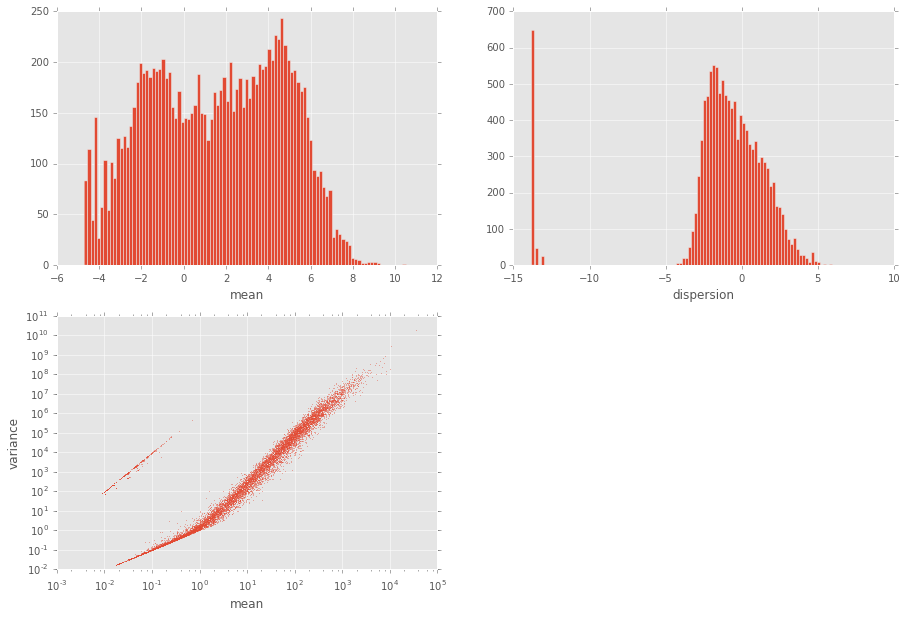

In [5]:
_plt.figure(figsize=(15,10))
_plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
_plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
_plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');

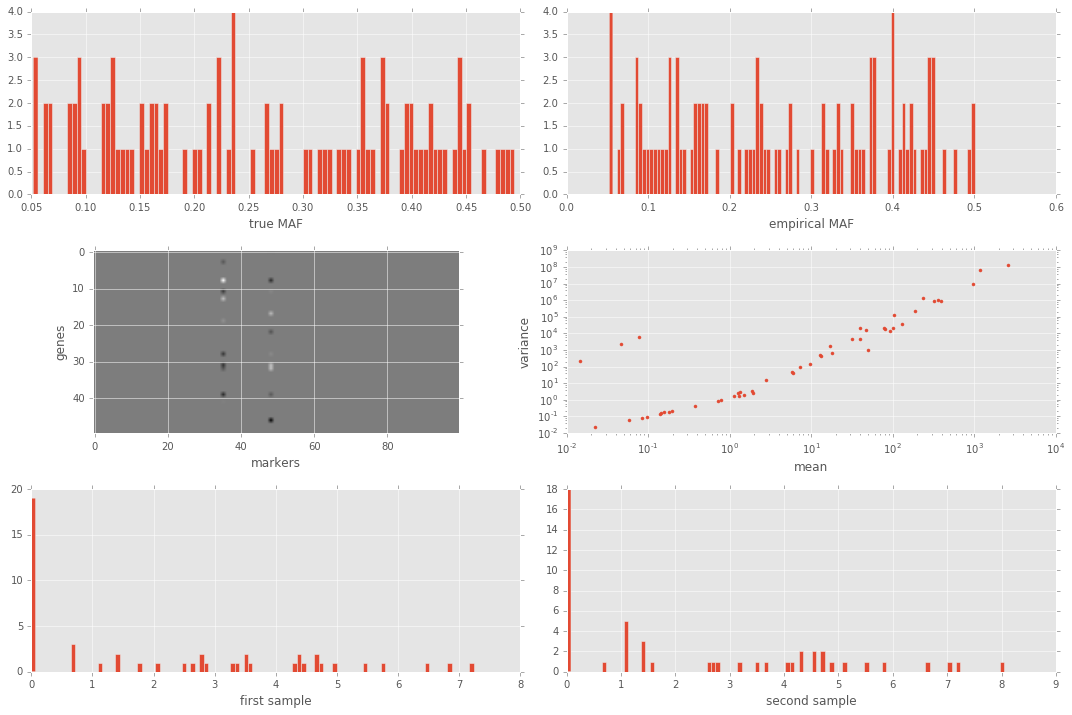

In [6]:
n_samples = 2000
n_markers = 100
n_markers_causal = 2
n_genes = 50
n_genes_affected = 10

data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range=[0.05, 0.5])
data_pheno = _assoc.simulate_eQTL_nbinom(data_geno['G'], pars['mu'], pars['phi'], n_markers_causal, n_genes, n_genes_affected, h2=0.5)

_plt.figure(figsize = (15,10));
_plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
_plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
_plt.subplot(3,2,3); _plt.imshow(data_pheno['coefs'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
_plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
_plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Y'][0,:]+1), 100); _plt.xlabel('first sample');
_plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Y'][1,:]+1), 100); _plt.xlabel('second sample');
_plt.tight_layout()

In [7]:
Y, _ = _utils.normalise_RNAseq_data(data_pheno['Y'].T)
res = _assoc.mdl_nbinom_gibbs(Y.T, data_geno['G'], n_iters = 1000, phi_prior='LN')

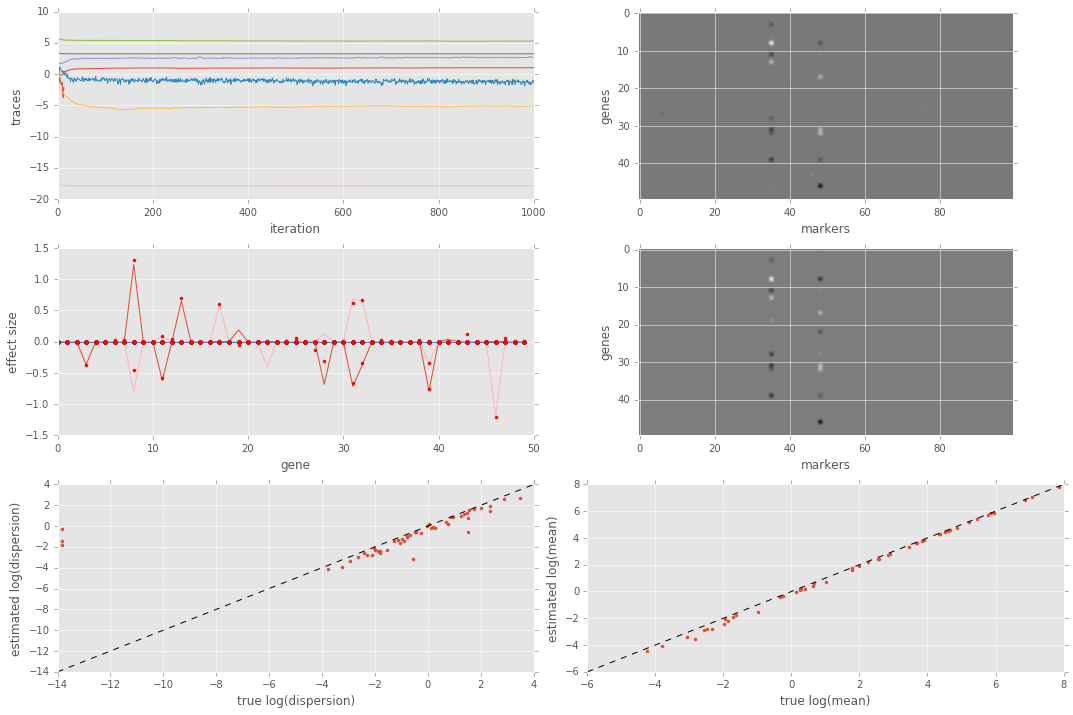

In [8]:
_plt.figure(figsize = (15,10));
_plt.subplot(3,2,1); _plt.plot(_nmp.log(res['traces'][1:,:])); _plt.xlabel('iteration'); _plt.ylabel('traces')
_plt.subplot(3,2,2); _plt.imshow(res['beta_mean'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes');
_plt.subplot(3,2,3); _plt.plot(data_pheno['coefs']); _plt.plot(res['beta_mean'], '.r'); _plt.xlabel('gene'); _plt.ylabel('effect size')
_plt.subplot(3,2,4); _plt.imshow(data_pheno['coefs'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes');
_plt.subplot(3,2,5); _plt.plot(_nmp.log(data_pheno['phi']), _nmp.log(res['phi_mean']), '.'); 
_plt.ylim(_plt.xlim()); _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); _plt.xlabel('true log(dispersion)'); _plt.ylabel('estimated log(dispersion)')
_plt.subplot(3,2,6); _plt.plot(_nmp.log(data_pheno['mu']), _nmp.log(res['mu_mean']), '.'); 
_plt.ylim(_plt.xlim()); _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); _plt.xlabel('true log(mean)'); _plt.ylabel('estimated log(mean)')
_plt.tight_layout()